# Cosmological Plots for Cosmolunch App

This notebook demonstrates key cosmological quantities using the [CLASS](http://class-code.net/) code. The following plots correspond to figures from *Dodelson, Modern Cosmology* and are intended to help visualize the evolution of the universe.
*These plots will serve as the foundation for the streaming features in the Cosmolunch app.*


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from classy import Class
import matplotlib
import healpy as hp
from matplotlib.patches import FancyArrowPatch

In [ ]:
cosmo = Class()
common_settings = {
    'h': 0.6,
    'omega_b': 0.0224,
    'omega_cdm': 0.1188,
    'n_s': 0.96,
    'sigma8': 0.8,
    'l_max_scalars': 2500,
    'tau_reio': 0.054,
    'output': 'tCl,pCl,lCl',
    'gauge':'newtonian',
}

---

## 1. CMB Angular Power Spectrum 
**(Corresponds to Figure 1.10 in Dodelson)**  
- Plot the CMB angular power spectrum, $C_\ell$, as a function of multipole moment ($\ell$).
- Use a log-log scale to illustrate the behavior of the power spectrum at different scales.

---




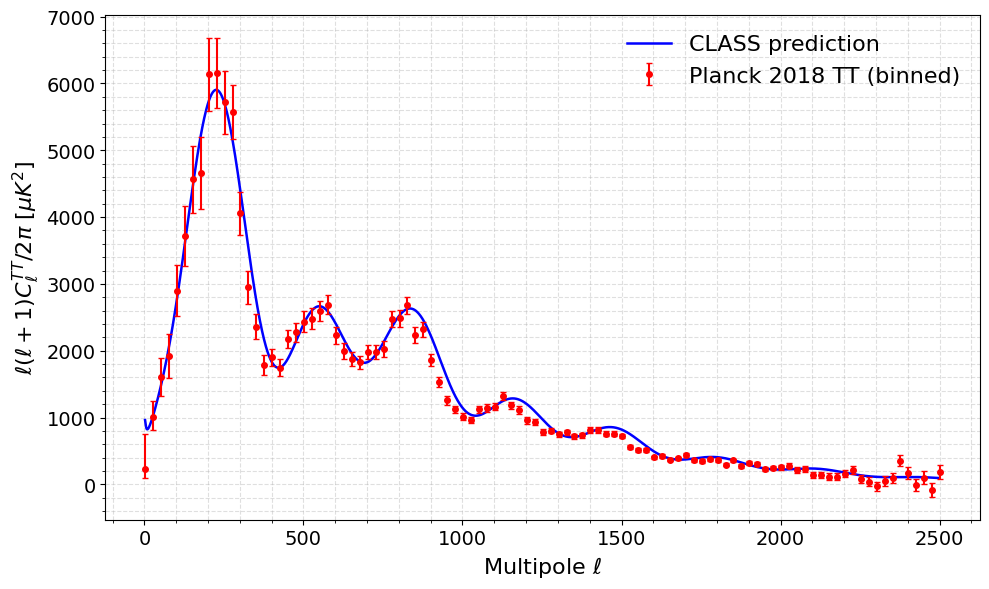

In [7]:
cosmo = Class()
cosmo.set(common_settings)
cosmo.compute()


# Get C_l^TT from CLASS (in [\mu K^2])
cl = cosmo.raw_cl(2500)
# Get the C_l^TT values
ells = cl['ell'][2:]  # drop ell=0,1
cl_tt = cl['tt'][2:] 

planck_data = np.loadtxt('/Users/r.kanaki/code/lunch_seminar/Data/COM_PowerSpect_CMB-TT-full_R3.01.txt')
ell_data = planck_data[:, 0]
cl_data = planck_data[:, 1]
cl_err_plus = planck_data[:, 2]
cl_err_minus = planck_data[:, 3]


# Downsample CLASS prediction
step = 25
ell_sampled = ell_data[::step]
cl_sampled = cl_data[::step]
cl_err_plus_sampled = cl_err_plus[::step]
cl_err_minus_sampled = cl_err_minus[::step]

T0 = 2.7255  * 1e6 # [K^2] to [μK^2]
# Convert to [μK^2]
cl_tt = cl_tt * T0**2  # [μK^2]

# Plotting (Planck-style)
plt.figure(figsize=(10, 6))
plt.plot(ells, cl_tt * ells * (ells + 1) / (2 * np.pi), lw=1.8, color='blue', label='CLASS prediction')

plt.errorbar(ell_sampled, cl_sampled, yerr=[cl_err_plus_sampled, cl_err_minus_sampled], fmt='o', markersize=4, capsize=2, color='red', label='Planck 2018 TT (binned)')

plt.xlabel(r'Multipole $\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi\ [\mu K^2]$', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tick_params(labelsize=14)
plt.legend(fontsize=16, loc='upper right', frameon=False)
# Optional: Add Planck-like tick styling
plt.minorticks_on()
plt.tight_layout()
plt.show()

# Cleanup CLASS
cosmo.struct_cleanup()
cosmo.empty()

---

## 2. CMB Temperature Anisotropies Map



---




/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_90946/489735678.py:3: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)


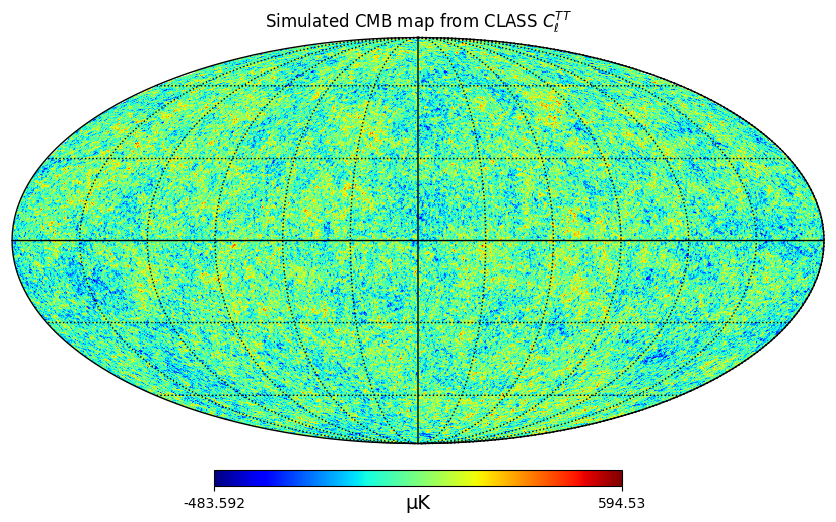

In [8]:
nside = 1024  # or 1024 for higher resolution
lmax = 2500
cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)
hp.mollview(cmb_map, title='Simulated CMB map from CLASS $C_\ell^{TT}$', unit='μK', cmap='jet')
hp.graticule()

/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_90946/2646641808.py:12: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)


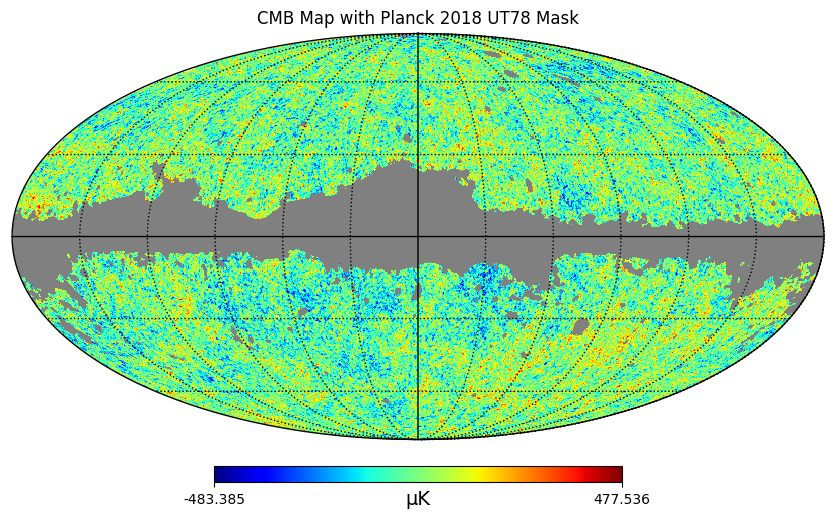

In [9]:
# === Load Planck 2018 UT78 Mask ===
mask_path = "/Users/r.kanaki/code/lunch_seminar/Data/COM_Mask_CMB-common-Mask-int_2048_R3.00.fits"
mask_2048 = hp.read_map(mask_path)

# Downgrade mask to match your map nside (e.g., 1024)
nside = 1024
mask = hp.ud_grade(mask_2048, nside_out=nside)
mask = np.where(mask > 0.9, 1, 0)  # Binarize mask

# === Simulate CMB map ===
lmax = 2500
cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)

# === Apply mask ===
cmb_map_masked = cmb_map * mask
# Set masked pixels to hp.UNSEEN so they appear as background in the plot
cmb_map_masked[mask == 0] = hp.UNSEEN
# === Plot ===
hp.mollview(cmb_map_masked, title='CMB Map with Planck 2018 UT78 Mask', unit='μK', cmap='jet')
hp.graticule()

---
## 3. CMB Polarization and Temperature Power Spectrum
**(Corresponds to Figure 10.11 in Dodelson)**


---




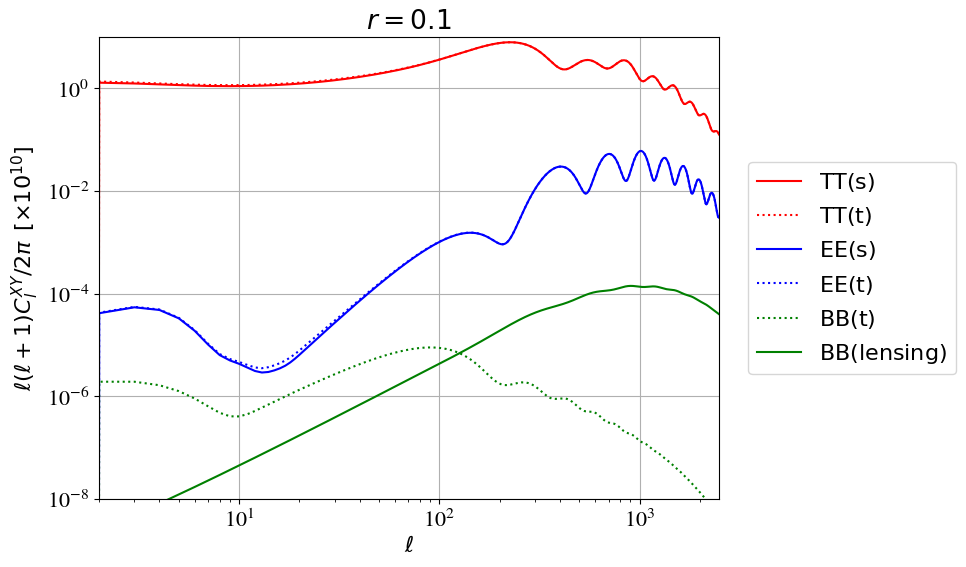

In [11]:
l_max_scalars = 2500
l_max_tensors = 2500
M_s= Class()
M_s.set(common_settings)
M_s.set({'output':'tCl,pCl,lCl','modes':'s','lensing':'yes',
       'l_max_scalars':l_max_scalars})
M_s.compute()

M_t = Class()
M_t.set(common_settings)
M_t.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_t':0,
       'l_max_scalars':l_max_scalars,'l_max_tensors':l_max_tensors})
M_t.compute()


clt = M_t.raw_cl(l_max_scalars)
cls = M_s.raw_cl(l_max_scalars)
cl_lensed = M_t.lensed_cl(l_max_scalars)
font = {'size'   : 16, 'family':'STIXGeneral'}


axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

#################
#
# plotting
#
#################
#
plt.xlim([2,l_max_scalars])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cls['ell']
ellt = clt['ell']    
factor = 1.e10*ell*(ell+1.)/2./np.pi
factort = 1.e10*ellt*(ellt+1.)/2./np.pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-clt['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

---
## 4. CMB Polarization Map
---




/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_90946/3935262982.py:10: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_maps = hp.synfast(cl_synfast, nside=nside, lmax=lmax, new=True, pol=True, verbose=False)


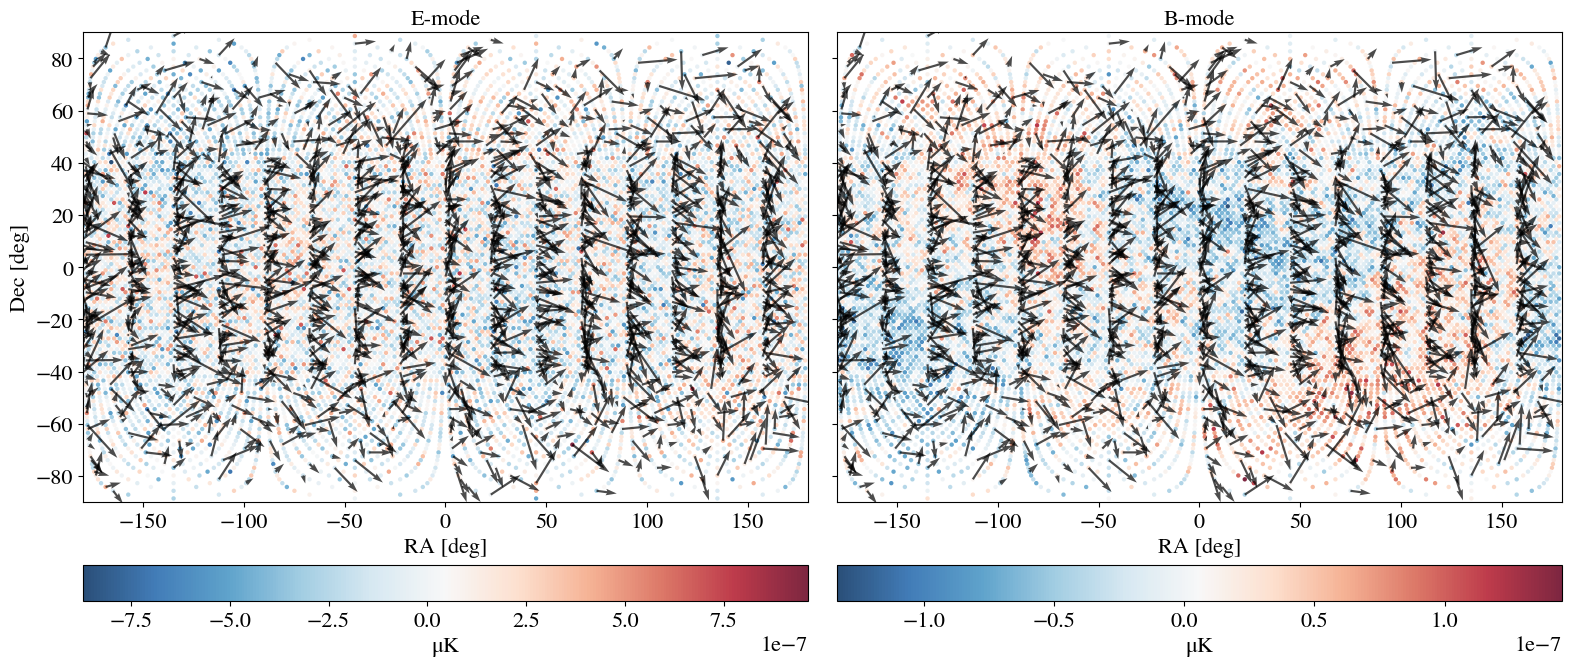

In [12]:
# Generate simulated CMB polarization maps (E and B modes) from the lensed power spectra
# Use cl_lensed['ee'] and cl_lensed['bb'] for E and B modes, respectively

# Prepare the input power spectra for synfast: [TT, EE, BB, TE]
# TT is not needed for pure polarization, but synfast expects a 4-list
cl_synfast = [cl_lensed['tt'], cl_lensed['ee'], cl_lensed['bb'], cl_lensed['te']]

# Generate Q and U maps (Stokes parameters) using healpy.synfast
# Set pol=True to get polarization maps
cmb_maps = hp.synfast(cl_synfast, nside=nside, lmax=lmax, new=True, pol=True, verbose=False)
cmb_T, cmb_Q, cmb_U = cmb_maps  # T, Q, U maps



# Optionally, decompose Q/U into E/B maps using healpy
alm_EB = hp.map2alm([cmb_T, cmb_Q, cmb_U], pol=True, lmax=lmax)
cmb_E = hp.alm2map(alm_EB[1], nside=nside, lmax=lmax)
cmb_B = hp.alm2map(alm_EB[2], nside=nside, lmax=lmax)

nside_plot = 32 # lower resolution for vector field visualization
npix = hp.nside2npix(nside_plot)
theta, phi = hp.pix2ang(nside_plot, np.arange(npix))

# Downsample Q/U/E/B maps for plotting
Q_plot = hp.ud_grade(cmb_Q, nside_plot)
U_plot = hp.ud_grade(cmb_U, nside_plot)
E_plot = hp.ud_grade(cmb_E, nside_plot)
B_plot = hp.ud_grade(cmb_B, nside_plot)

# Convert spherical to Mollweide projection coordinates
lon = np.rad2deg(phi) - 180  # [-180, 180]
lat = 90 - np.rad2deg(theta) # [-90, 90]

# Compute polarization angles and amplitudes
pol_angle = 0.5 * np.arctan2(U_plot, Q_plot)
pol_amp = np.sqrt(Q_plot**2 + U_plot**2)

# Normalize arrows for visibility
arrow_scale = 0.04 * pol_amp / pol_amp.max()

fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Plot settings
arrow_skip = 8  # plot every Nth arrow for clarity
x = lon[::arrow_skip]
y = lat[::arrow_skip]
u = arrow_scale[::arrow_skip] * np.cos(pol_angle[::arrow_skip])
v = arrow_scale[::arrow_skip] * np.sin(pol_angle[::arrow_skip])

# E-mode
im0 = axs[0].scatter(lon, lat, c=E_plot, cmap='RdBu_r', s=10, lw=0, alpha=0.85)
axs[0].quiver(x, y, u, v, color='k', alpha=0.7, width=0.003, scale=0.4)
axs[0].set_title('E-mode', fontsize=16)
axs[0].set_xlabel('RA [deg]')
axs[0].set_ylabel('Dec [deg]')
axs[0].set_xlim([-180, 180])
axs[0].set_ylim([-90, 90])
fig.colorbar(im0, ax=axs[0], orientation='horizontal', pad=0.1, label='μK')

# B-mode
im1 = axs[1].scatter(lon, lat, c=B_plot, cmap='RdBu_r', s=10, lw=0, alpha=0.85)
axs[1].quiver(x, y, u, v, color='k', alpha=0.7, width=0.003, scale=0.4)
axs[1].set_title('B-mode', fontsize=16)
axs[1].set_xlabel('RA [deg]')
axs[1].set_xlim([-180, 180])
axs[1].set_ylim([-90, 90])
fig.colorbar(im1, ax=axs[1], orientation='horizontal', pad=0.1, label='μK')

plt.tight_layout()
plt.show()
